✅ Loaded dataset with shape: (12316, 32)
🔍 Running GridSearchCV...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

📊 All parameter combinations with F1 and Accuracy:

1) Params: {'learning_rate': 0.05, 'max_depth': 10, 'max_iter': 100} --> Mean F1: 0.8589 | Mean Accuracy: 0.8604
2) Params: {'learning_rate': 0.05, 'max_depth': 10, 'max_iter': 200} --> Mean F1: 0.8866 | Mean Accuracy: 0.8874
3) Params: {'learning_rate': 0.05, 'max_depth': None, 'max_iter': 100} --> Mean F1: 0.8606 | Mean Accuracy: 0.8620
4) Params: {'learning_rate': 0.05, 'max_depth': None, 'max_iter': 200} --> Mean F1: 0.8896 | Mean Accuracy: 0.8903
5) Params: {'learning_rate': 0.1, 'max_depth': 10, 'max_iter': 100} --> Mean F1: 0.8862 | Mean Accuracy: 0.8869
6) Params: {'learning_rate': 0.1, 'max_depth': 10, 'max_iter': 200} --> Mean F1: 0.9055 | Mean Accuracy: 0.9057
7) Params: {'learning_rate': 0.1, 'max_depth': None, 'max_iter': 100} --> Mean F1: 0.8900 | Mean Accuracy: 0.8908
8) Params: {'learning_rate

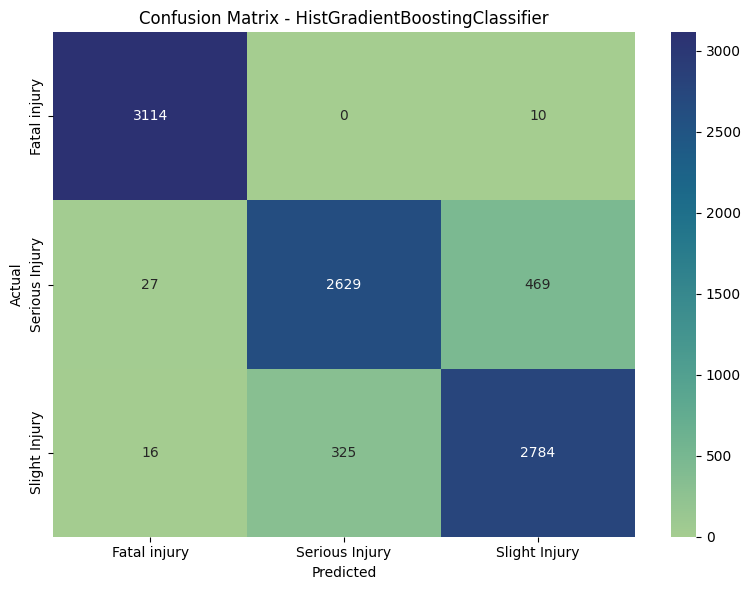

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Load dataset
df = pd.read_csv("RTA Dataset.csv")
print("✅ Loaded dataset with shape:", df.shape)

# Selected features and target
selected_features = [
    'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver', 'Educational_level',
    'Vehicle_driver_relation', 'Driving_experience', 'Type_of_vehicle',
    'Owner_of_vehicle', 'Service_year_of_vehicle', 'Defect_of_vehicle',
    'Area_accident_occured', 'Lanes_or_Medians', 'Road_allignment',
    'Types_of_Junction', 'Road_surface_type', 'Road_surface_conditions',
    'Light_conditions', 'Weather_conditions', 'Type_of_collision',
    'Number_of_vehicles_involved', 'Number_of_casualties',
    'Vehicle_movement', 'Cause_of_accident'
]
target = 'Accident_severity'

# Handle missing values and label encode
df = df[selected_features + [target]]
label_encoders = {}
for col in df.columns:
    le = LabelEncoder()
    df[col] = df[col].fillna('Unknown') if df[col].dtype == 'object' else df[col].fillna(df[col].mean())
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Feature-target split
X = df.drop(columns=[target])
y = df[target]

# Apply SMOTE to balance classes
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X, y)


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

# Grid SearchCV
param_grid = {
    'learning_rate': [0.05, 0.1],
    'max_iter': [100, 200],
    'max_depth': [10, None]
}
print("🔍 Running GridSearchCV...")
grid_search = GridSearchCV(
    HistGradientBoostingClassifier(random_state=42),
    param_grid,
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Print grid search results
print("\n📊 All parameter combinations with F1 and Accuracy:\n")
for i, params in enumerate(grid_search.cv_results_['params']):
    f1 = grid_search.cv_results_['mean_test_score'][i]
    model = HistGradientBoostingClassifier(**params, random_state=42)
    acc = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=StratifiedKFold(n_splits=5)).mean()
    print(f"{i+1}) Params: {params} --> Mean F1: {f1:.4f} | Mean Accuracy: {acc:.4f}")

# Best model evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\n✅ Best Model Evaluation:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest',
            xticklabels=label_encoders[target].classes_,
            yticklabels=label_encoders[target].classes_)
plt.title("Confusion Matrix - HistGradientBoostingClassifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


